In [2]:
# 导入相应的库
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import datetime

In [3]:
# 定义超参数
# 训练批次大小
train_batch_size = 64
# 测试批次大小
test_batch_size = 64
# 学习率
learning_rate = 0.01
# 迭代次数
num_epoches = 100

#动量
momentum = 0

#丢弃率
dropout_rate = 0.5
#判断是否有GPU，如果有则使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

#标签顺序
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [4]:
# 定义预处理函数
transform = transforms.Compose([
    #将图像数据转换为张量
    transforms.ToTensor(), 
    #将图像数据归一化到[-1,1]
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #随机水平翻转
    # transforms.RandomHorizontalFlip(),
    # #随机遮挡
    # transforms.RandomErasing(scale=(0.04,0.2), ratio=(0.5,2)),
    # #随机裁剪
    # transforms.RandomCrop(32, padding=4)
])  

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
#下载数据，并对数据进行预处理
mnist_train= torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,download=True) 
mnist_test= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test,download=True)
mnist_show= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(),download=False)
#得到一个生成器
train_loader = DataLoader(mnist_train, batch_size=train_batch_size)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size)
show_loader = DataLoader(mnist_show, batch_size=test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


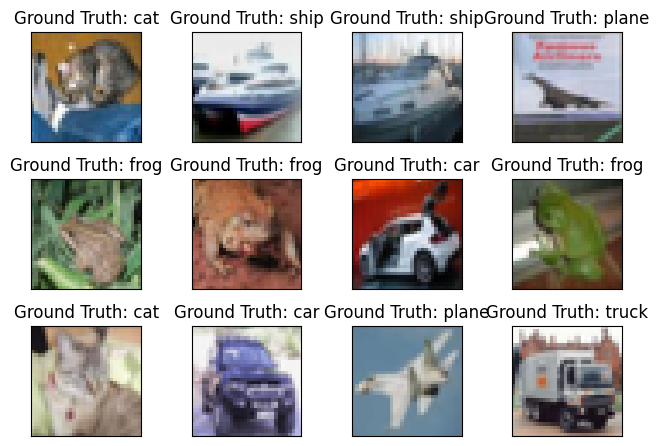

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
torch.Size([64])


In [5]:
# 可视化源数据
# 打印测试集数据标签
examples = enumerate(show_loader) #用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标

batch_idx, (imgs, labels) = next(examples) #读取数据,batch_idx从0开始
#绘制部分数据图像
fig = plt.figure() #创建一个图像
for i in range(12):
    plt.subplot(3,4,i+1) #3行4列，第i+1个子图
    plt.tight_layout() #自动调整子图参数,使之填充整个图像区域
    plt.imshow(imgs[i].permute(1,2,0), interpolation='none') #绘制图像
    plt.title("Ground Truth: {}".format(classes[labels[i].item()])) #设置标题
    plt.xticks([]) #设置x轴刻度为空
    plt.yticks([]) #设置y轴刻度为空
plt.show() #显示图像
print(labels) #读取标签数据
print(labels.shape) #torch.Size([32])，因为batch_size为32

In [6]:
# 构建模型
class Net(nn.Module):
    # """
    # 使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    # """
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            #lenet-5
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            # 激活函数
            nn.Sigmoid(),
            #新增的隐藏层
            # nn.Linear(256, 64),
            # 激活函数
            # nn.ReLU(True),
            nn.Linear(64, 10),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
#创建模型实例
model = Net().to(device)
# 损失函数
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# 其他几种优化算法：
# opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
# opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
# opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
# opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))




In [7]:
# 训练模型并绘制Loss函数曲线
print('start training')
iterations = 0
#记录数据
losses = []
acces = []
eval_losses = []
eval_acces = []

#开始计时
start = datetime.datetime.now()

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print('lr is set to {}'.format(optimizer.param_groups[0]['lr']))
    for img,label in train_loader:
        img,label = img.to(device),label.to(device)
        #前向传播
        out = model(img)
        #计算损失
        loss = criterion(out,label)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #记录误差
        train_loss += loss.item()
        #计算准确率
        _,pred = torch.max(out,1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses.append(train_loss/len(train_loader))
    acces.append(train_acc/len(train_loader))
    #在测试集上测试
    eval_loss = 0
    eval_acc = 0

    model.eval()
    for img,label in test_loader:
        img,label = img.to(device),label.to(device)
        out = model(img)
        loss = criterion(out,label)
        #记录误差
        eval_loss += loss.item()
        #计算准确率
        _,pred = torch.max(out,1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Test Loss: {:.6f}, Test Acc: {:.6f}'
          .format(epoch, train_loss/len(train_loader), train_acc/len(train_loader), 
                  eval_loss/len(test_loader), eval_acc/len(test_loader)))
#结束计时
end = datetime.datetime.now()
# 绘制损失函数曲线
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, "blue", label="Training Loss")
plt.plot(np.arange(len(eval_losses)), eval_losses, "red", label="Test Loss")
plt.xlim([0,epoch])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.savefig('./loss_sigmoid.png')
# 计算训练时间
print('time used: ', end-start)
torch.save(model,'./model/model_sigmoid.ckpt')


start training
lr is set to 0.009000000000000001
epoch: 0, Train Loss: 2.298938, Train Acc: 0.135350, Test Loss: 2.287377, Test Acc: 0.155752
epoch: 1, Train Loss: 2.256271, Train Acc: 0.205083, Test Loss: 2.226133, Test Acc: 0.232584
epoch: 2, Train Loss: 2.208510, Train Acc: 0.233656, Test Loss: 2.187899, Test Acc: 0.250995
epoch: 3, Train Loss: 2.174834, Train Acc: 0.252697, Test Loss: 2.158237, Test Acc: 0.266819
epoch: 4, Train Loss: 2.151194, Train Acc: 0.262968, Test Loss: 2.139827, Test Acc: 0.273288
lr is set to 0.008100000000000001
epoch: 5, Train Loss: 2.136236, Train Acc: 0.268622, Test Loss: 2.127468, Test Acc: 0.280155


KeyboardInterrupt: 

In [ ]:
# 测试模型在一个或数个batch的分类情况，并输出图像及对应预测名称，打印正确率
print('start testing')
#加载模型
model_test = torch.load('./model/model_sigmoid.ckpt')
#设置模型为评估模式
model_test.eval()
#设置测试集
mytest = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(),download=True)
mytest_loader = torch.utils.data.DataLoader(mytest, batch_size=test_batch_size, shuffle=True)
#归一化
test_transform = transforms.Compose([
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # transforms.ToPILImage()
])
eval_loss = 0
eval_acc = 0
fig = plt.figure()
#batch 循环
for i,(img,label) in enumerate(mytest_loader):
    img,label = img.to(device),label.to(device)
    test_img = img
    img = test_transform(img)
    out = model_test(img)
    loss = criterion(out,label)
    #记录误差
    eval_loss += loss.data.item()*label.size(0)
    #计算准确率
    _,pred = torch.max(out,1)
    num_correct = (pred == label).sum().item()
    eval_acc += num_correct

    #绘制图片（归一化后）
    if i == 0:
        for j in range(6):
            plt.subplot(2,3,j+1)
            plt.tight_layout()
            plt.imshow(test_img[j].permute(1,2,0), interpolation='none')
            plt.title('Prediction: {}'.format(classes[pred[j].item()]))
            plt.xticks([])
            plt.yticks([])
plt.show()
print('Test Loss: {:.6f}, Test Acc: {:.6f}'.format(eval_loss/len(mytest), eval_acc/len(mytest)))